## Imports and Load Data 

In [227]:
# Imports

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import scikitplot as skplt

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import itertools

In [228]:
# Loading datasets and checking their shape

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)
total = pd.concat([train, test], ignore_index=True)

print(f"Shape of train data: {train.shape}")
print(f"Shape of test data: {test.shape}")
print(f"Shape of total data: {total.shape}")

target = 'smoking'

train.head(3)

Shape of train data: (159256, 23)
Shape of test data: (106171, 22)
Shape of total data: (265427, 23)


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1


## Explorative Data Analysis 

In [229]:
# inspecting distribution of single variables

train.describe().T\
    .style.background_gradient(subset=['mean'], cmap='Blues')\
    .background_gradient(subset=['std'], cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
age,159256.000000,44.306626,11.842286,20.000000,40.000000,40.000000,55.000000,85.000000
height(cm),159256.000000,165.266929,8.818970,135.000000,160.000000,165.000000,170.000000,190.000000
weight(kg),159256.000000,67.143662,12.586198,30.000000,60.000000,65.000000,75.000000,130.000000
waist(cm),159256.000000,83.001990,8.957937,51.000000,77.000000,83.000000,89.000000,127.000000
eyesight(left),159256.000000,1.005798,0.402113,0.100000,0.800000,1.000000,1.200000,9.900000
eyesight(right),159256.000000,1.000989,0.392299,0.100000,0.800000,1.000000,1.200000,9.900000
hearing(left),159256.000000,1.023974,0.152969,1.000000,1.000000,1.000000,1.000000,2.000000
hearing(right),159256.000000,1.023421,0.151238,1.000000,1.000000,1.000000,1.000000,2.000000
systolic,159256.000000,122.503648,12.729315,77.000000,114.000000,121.000000,130.000000,213.000000
relaxation,159256.000000,76.874071,8.994642,44.000000,70.000000,78.000000,82.000000,133.000000


- `id`: Unique identifier for each data point.
- `age`: Age of the individual, categorized in 5-year intervals.
- `height(cm)`: Height of the individual in centimeters.
- `weight(kg)`: Weight of the individual in kilograms.
- `waist(cm)`: Waist circumference of the individual in centimeters.
- `eyesight(left/right)`: Eyesight measurements for the left and right eyes.
- `hearing(left/right)`: Hearing ability for the left and right ears, represented as binary.
- `systolic`: Systolic blood pressure measurement.
- `relaxation`: Diastolic blood pressure measurement.
- `fasting blood sugar`: Fasting blood sugar level.
- `Cholesterol`: Total cholesterol level.
- `triglyceride`: Triglyceride level.
- `HDL`: High-density lipoprotein cholesterol level.
- `LDL`: Low-density lipoprotein cholesterol level.
- `hemoglobin`: Hemoglobin level in the blood.
- `Urine protein`: Level of protein in urine, categorized.
- `serum creatinine`: Serum creatinine level.
- `AST`: Level of aspartate aminotransferase enzyme.
- `ALT`: Level of alanine aminotransferase enzyme.
- `Gtp`: Level of gamma-glutamyl transferase enzyme.
- `dental caries`: Presence (1) or absence (0) of dental cavities.
- `smoking`: Target variable indicating if the individual is a smoker (1) or not (0). Not present in the test set but can be evaluated on [Kaggle](https://www.kaggle.com/competitions/playground-series-s3e24/overview). 

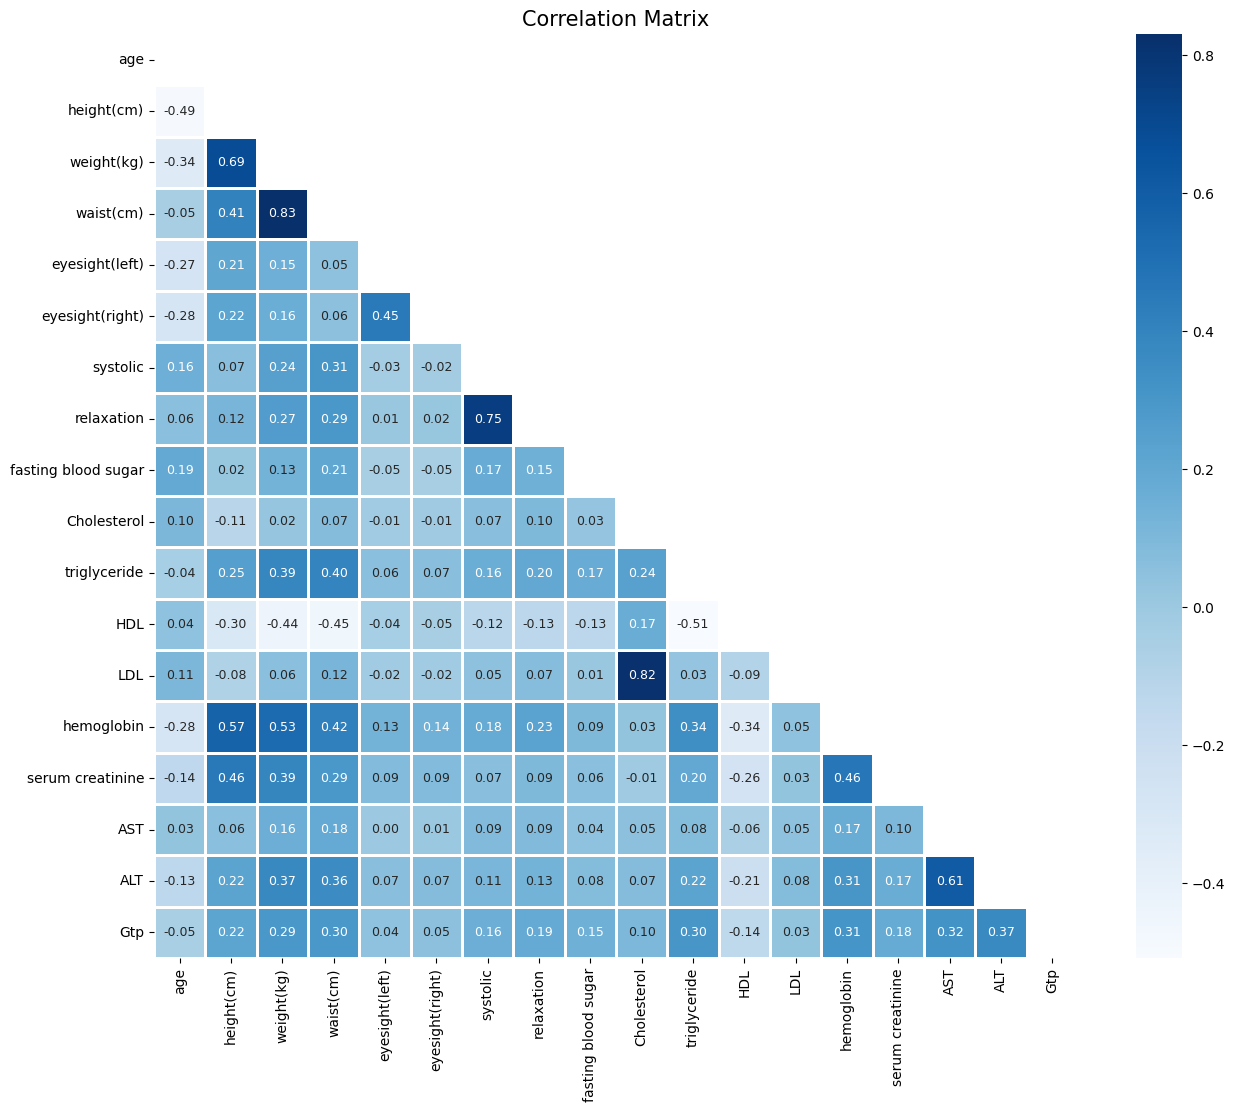

In [230]:
# Correlations

num_var = [column for column in test.columns if test[column].nunique() > 10]
corr_matrix = total[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

We see that there are not many high correlations between features, mainly between waist, height and weight which are rather obvious.    

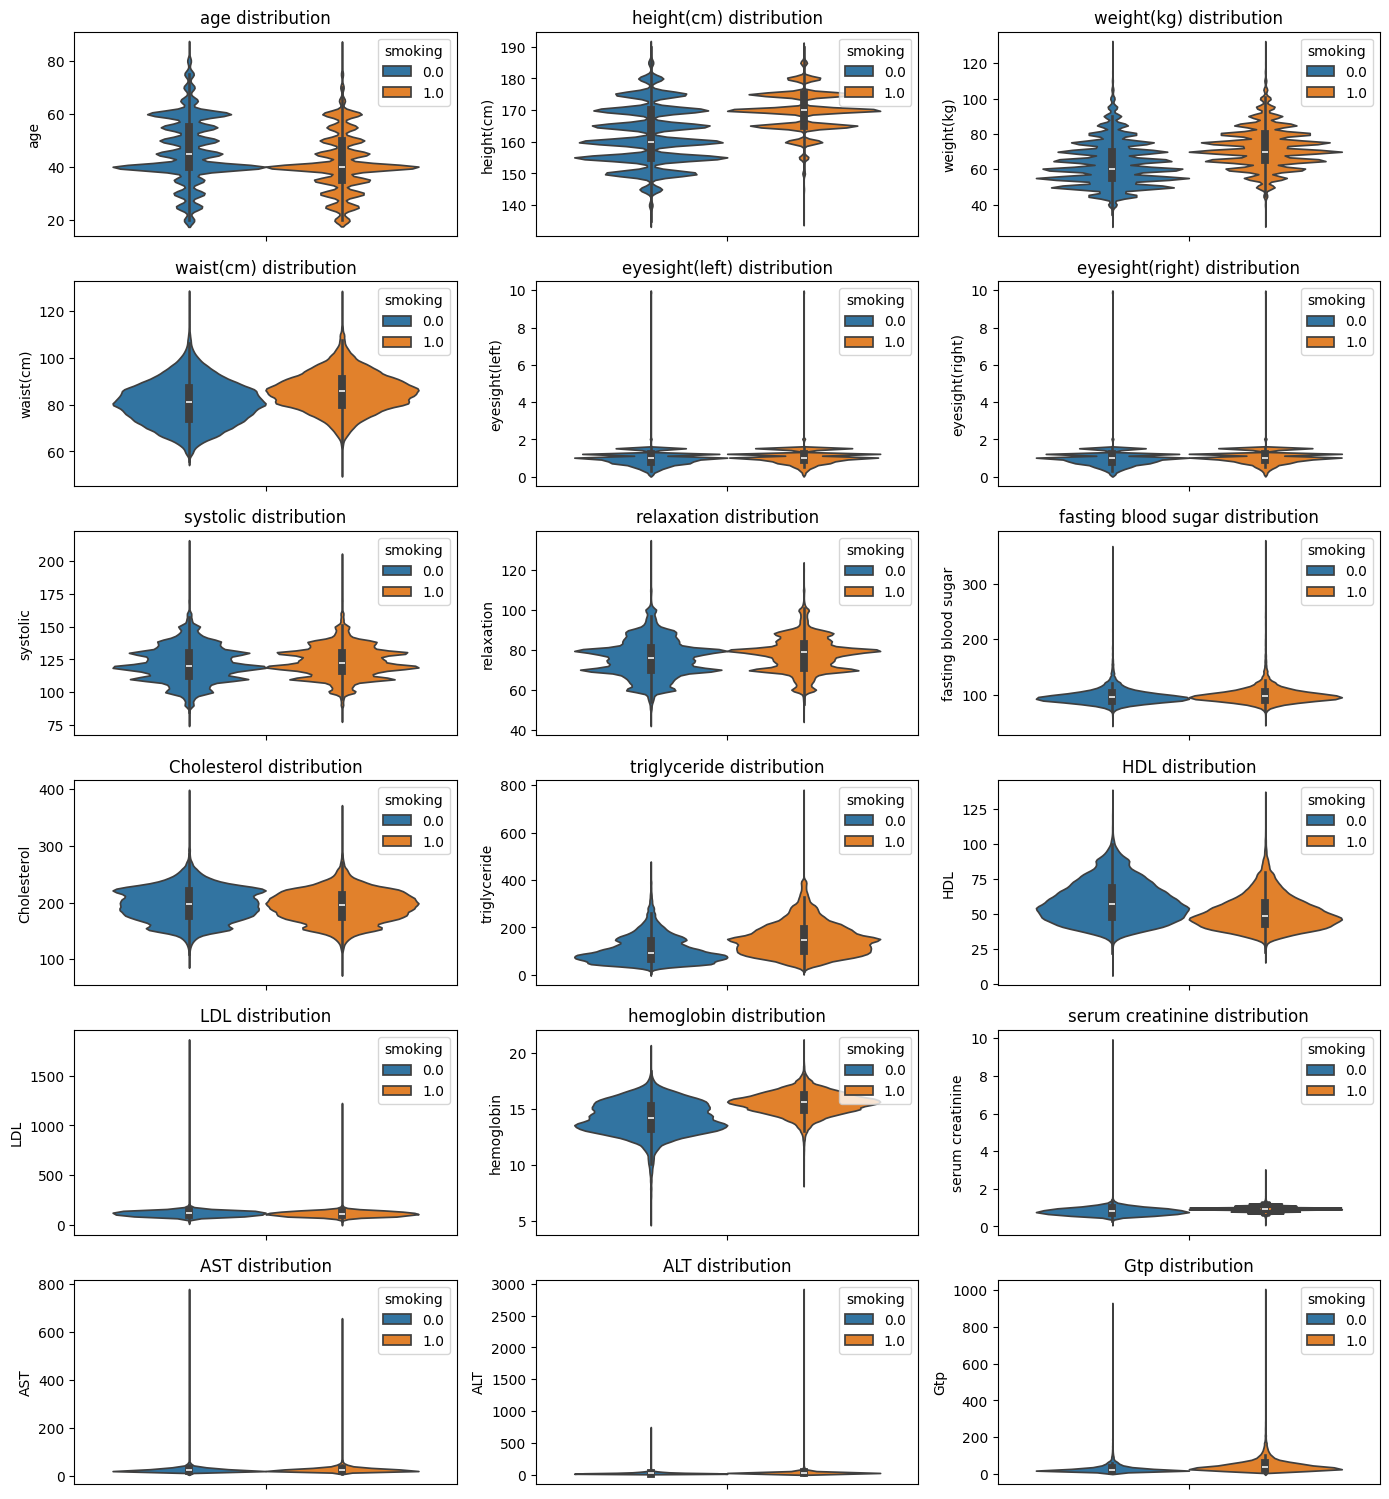

In [231]:
# Plot distributions of variables for smokers and non-smokers

num_rows = len(num_var)
num_cols = 3

total_plots = num_rows * num_cols
plt.figure(figsize=(14, num_rows * 2.5))

for idx, col in enumerate(num_var):
    plt.subplot(num_rows, num_cols, idx % total_plots + 1)
    sns.violinplot(hue=target, y=col, data=total)
    plt.title(f"{col} distribution")

plt.tight_layout()
plt.show()

We can see some differences between the distributions of the variables for smokers compared to non-smokers. There are significant differences in weight, hemoglobin and height. Also of interest is that the age distribution of non-smokers has a longer tail towards older ages.   

## Feature engineering

With a little domain knowledge we can add BMI as a feature representing the relation between height and weight and see that smokers have a significantly higher BMI.    

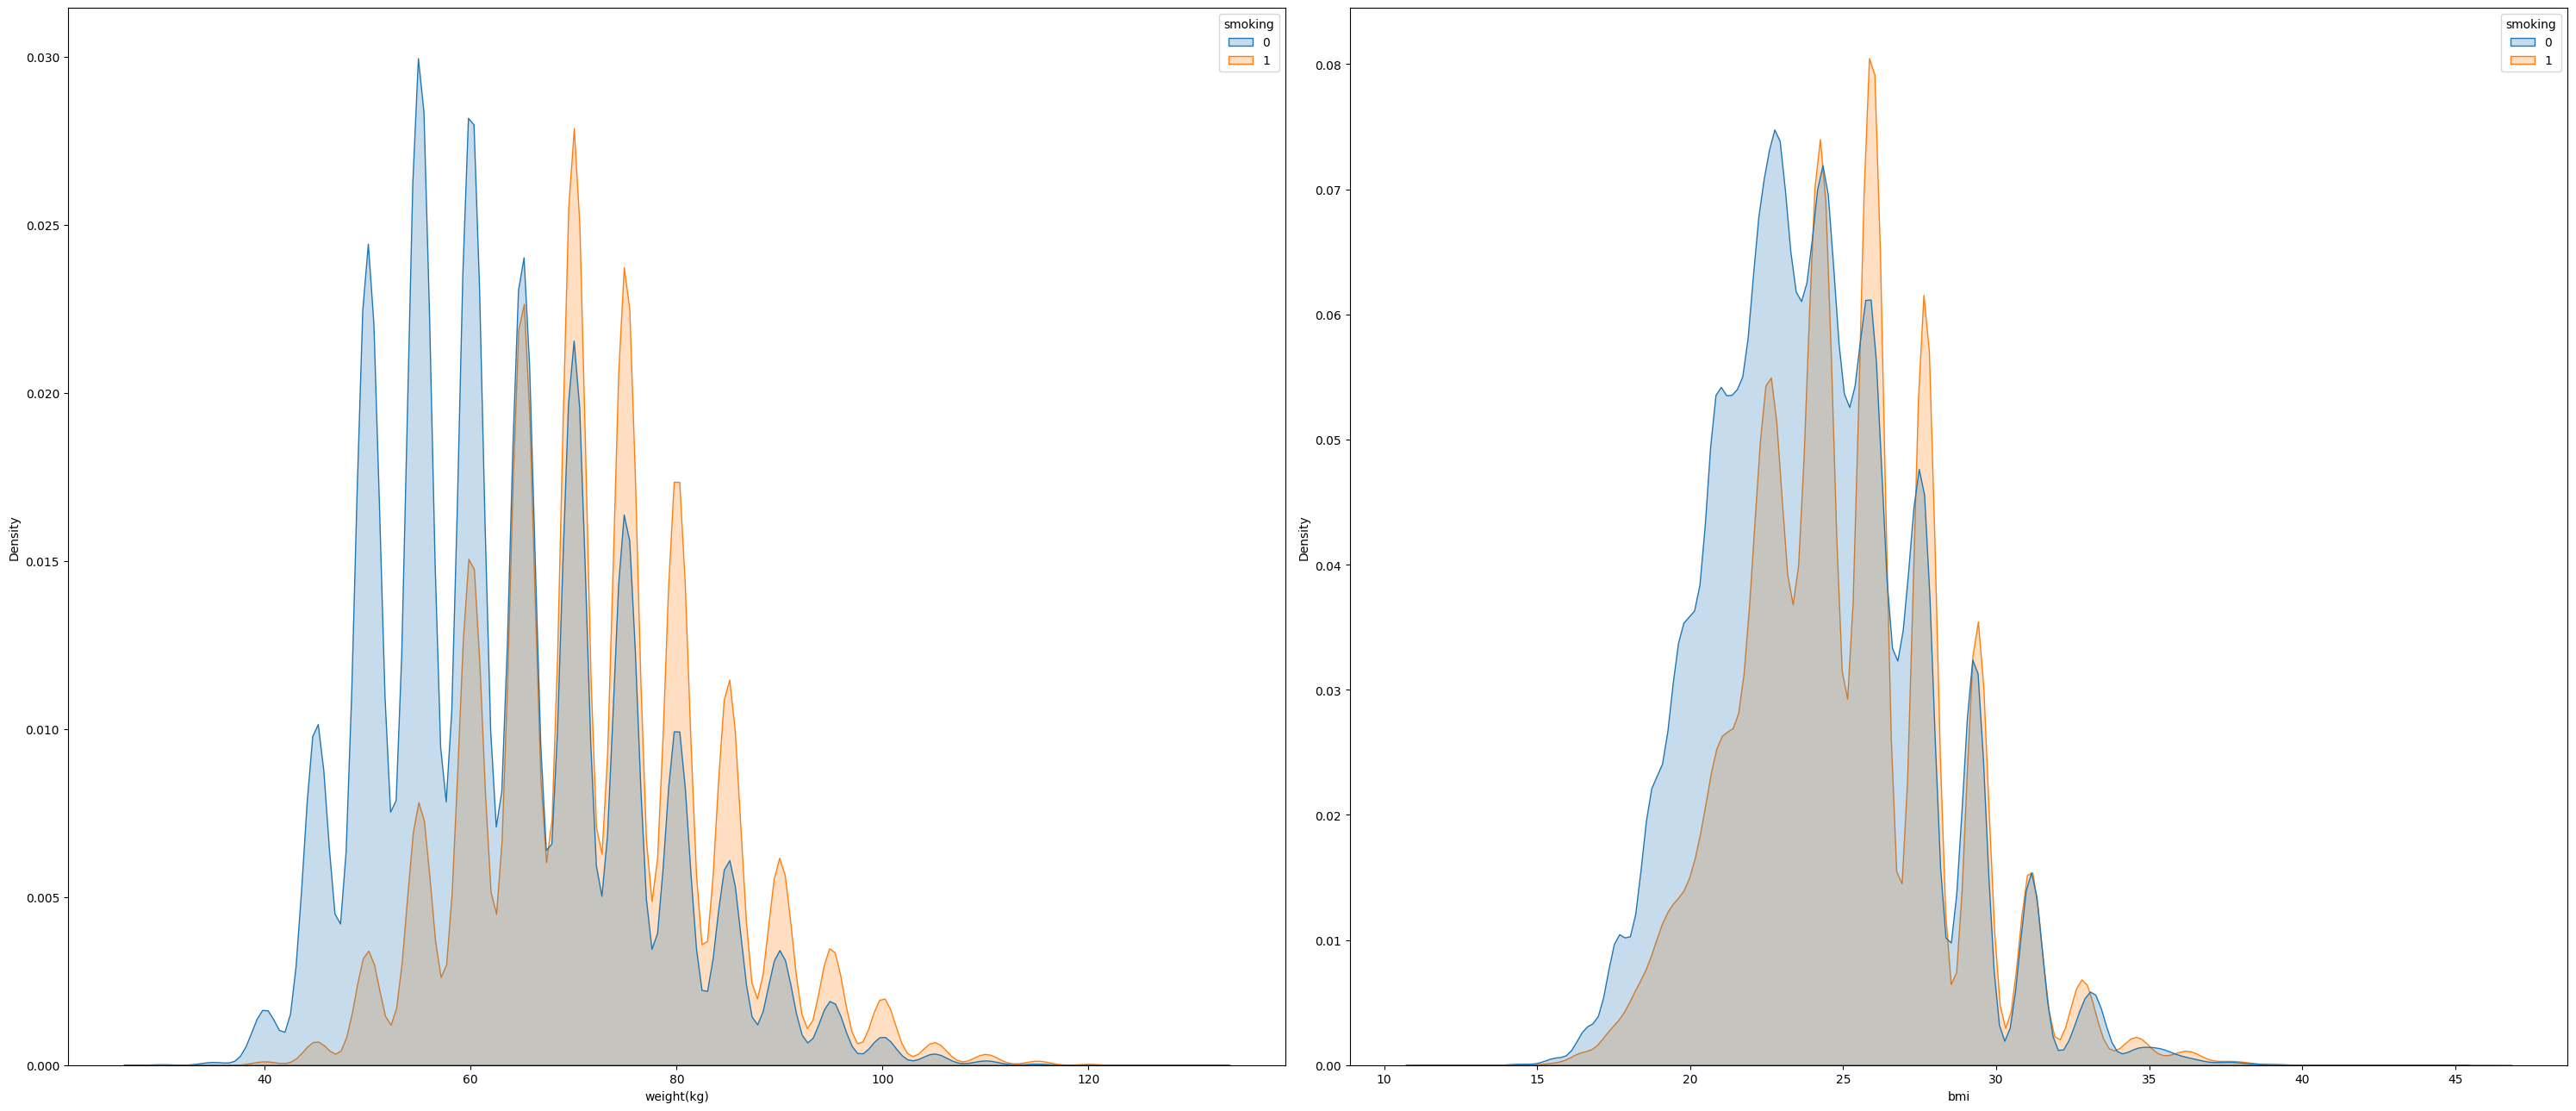

In [232]:
# Adding BMI as a feature and plotting distribution

def bmi_feature(df):
    df = df.copy()
    df['bmi'] = df['weight(kg)']/((df['height(cm)']/100)**2)
    return df

df = bmi_feature(train)

fig = plt.figure(figsize=(30, 13))

ax = fig.add_subplot(1, 2, 1)
sns.kdeplot(df, x='weight(kg)', hue=target,  fill=True, ax=ax)
ax = fig.add_subplot(1, 2, 2)
sns.kdeplot(df, x='bmi', hue=target,  fill=True, ax=ax)

plt.tight_layout()
plt.show()

In [233]:
# Further useful features proposed by the Kaggle community

def feature_eng(df):
    df = df.copy()
    df["HDL-LDL Ratio"] = df["HDL"] / df["LDL"]
    df["HDL-triglyceride Ratio"] = df["HDL"] / df["triglyceride"]
    df["LDL-triglyceride Ratio"] = df["LDL"] / df["triglyceride"]
    df["Liver Enzyme Ratio"] = df["AST"] / df["ALT"]
    return df

In [234]:
# Removing outliers using isolation forest
if_clf = IsolationForest(n_estimators = 2_000, contamination = 0.05, random_state = 42)

def remove_outliers(df):
    df = df.copy()
    if_pred = if_clf.fit_predict(df)
    df_outliers_removed = df[(if_pred == 1)]
    print(f"Removed {len(df) - len(df_outliers_removed)} outliers")
    print(df[(if_pred == -1)].head())
    return df_outliers_removed

#train = remove_outliers(train)

## Modeling 

Accuracy score on own test set: 0.7418058520658043
Area under ROC curve on own test set: 0.8250379040412278


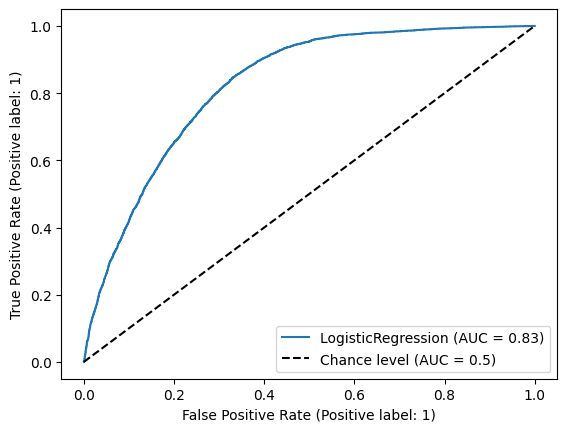

In [235]:
## Simple Logistic Regression model as a baseline

# For plotting
ROCs = []

# For readability again read data sets here:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
# train = feature_eng(remove_outliers(train))
# test = feature_eng(remove_outliers(test))
x = train.drop(["id",target],axis=1)
y = train[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, shuffle=True)

lg_clf = LogisticRegression(max_iter=1000)
lg_clf.fit(x_train, y_train)
preds = lg_clf.predict(x_test)
preds_proba = lg_clf.predict_proba(x_test)
print(f"Accuracy score on own test set: {lg_clf.score(x_test, y_test)}")
print(f"Area under ROC curve on own test set: {roc_auc_score(y_test, preds_proba[:,1])}")
#skplt.metrics.plot_roc_curve(y_test, lg_clf.predict_proba(x_test))
fpr, tpr, _ = metrics.roc_curve(y_test, preds_proba[:,1])
auc = round(metrics.roc_auc_score(y_test, preds_proba[:,1]), 4)
ROCs.append({'tpr':tpr, 'fpr':fpr, 'label':'Logistic Regression', 'auc':str(auc)})

RocCurveDisplay.from_estimator(lg_clf, x_test, y_test, plot_chance_level=True)
plt.show()

# Output for Kaggle's test set
test_preds = lg_clf.fit(x, y).predict_proba(test.drop(["id"], axis=1))
submission = pd.DataFrame({'id':test.id, 'smoking':test_preds[:,1]})
submission.to_csv("./output/log_reg_submission.csv", index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 62589, number of negative: 80741
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 143330, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436678 -> initscore=-0.254657
[LightGBM] [Info] Start training from score -0.254657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

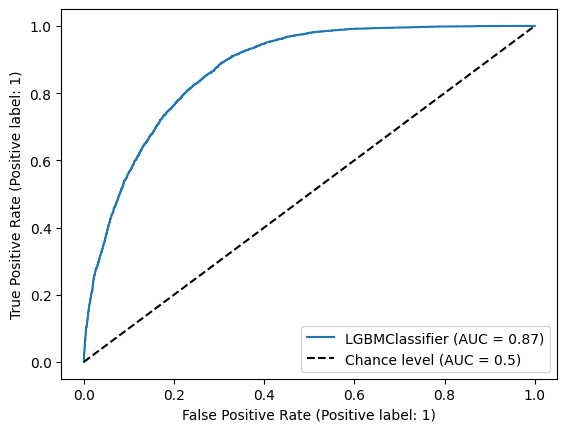

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 69653, number of negative: 89603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 159256, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251863
[LightGBM] [Info] Start training from score -0.251863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [236]:
## LGBM classifier

opt_lgb_params = {
                 'metric': 'binary_error',
                 'max_depth': 5,
                 'min_child_samples': 10,
                 'learning_rate': 0.045879163813688256,
                 'n_estimators': 1821,
                 'min_child_weight': 6,
                 'subsample': 0.11770708304786026,
                 'colsample_bytree': 0.49515159614595267,
                 'reg_alpha': 0.4218485459727929,
                 'reg_lambda': 0.28289526226193323
                  }

lgbm_clf = LGBMClassifier(**opt_lgb_params)

x = train.drop(["id",target],axis=1)
y = train[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, shuffle=True)
lgbm_clf.fit(x_train, y_train)
preds = lgbm_clf.predict(x_test)
preds_proba = lgbm_clf.predict_proba(x_test)
print(f"Accuracy score on own test set: {lgbm_clf.score(x_test, y_test)}")
print(f"Area under ROC curve on own test set: {roc_auc_score(y_test, preds_proba[:,1])}")
#skplt.metrics.plot_roc_curve(y_test, lg_clf.predict_proba(x_test))
fpr, tpr, _ = metrics.roc_curve(y_test, preds_proba[:,1])
auc = round(metrics.roc_auc_score(y_test, preds_proba[:,1]), 4)
ROCs.append({'tpr':tpr, 'fpr':fpr, 'label':'LGBM Classifier', 'auc':str(auc)})

RocCurveDisplay.from_estimator(lgbm_clf, x_test, y_test, plot_chance_level=True)
plt.show()

# Output for Kaggle's test set
test_preds = lgbm_clf.fit(x, y).predict_proba(test.drop(["id"], axis=1))
submission = pd.DataFrame({'id':test.id, 'smoking':test_preds[:,1]})
submission.to_csv("./output/lgbm_submission.csv", index=False)

Accuracy score on own test set: 0.7858847168152706
Area under ROC curve on own test set: 0.8704357518238047


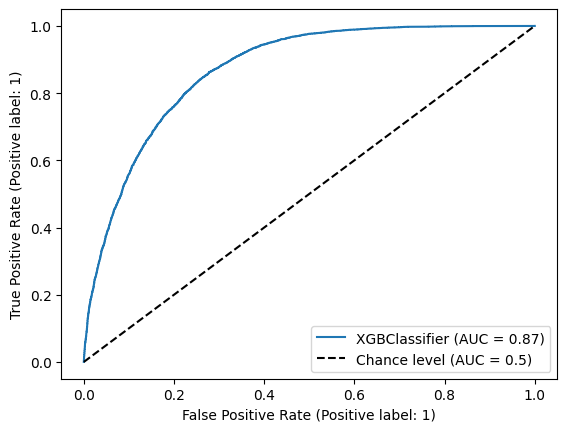

In [237]:
## XGB classifier

opt_xgb_params = {
                  'n_estimators': 2048,
                  'max_depth': 9,
                  'learning_rate': 0.045,
                  'booster': 'gbtree',
                  'subsample': 0.75,
                  'colsample_bytree': 0.30,
                  'reg_lambda': 1.00,
                  'reg_alpha': 0.80,
                  'gamma': 0.80,
                  'random_state': 42,
                  'objective': 'binary:logistic',
                  'eval_metric': 'auc',
                  'n_jobs': -1,
                 }

xgb_clf = XGBClassifier(**opt_xgb_params)

x = train.drop(["id",target],axis=1)
y = train[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, shuffle=True)
xgb_clf.fit(x_train, y_train)
preds = xgb_clf.predict(x_test)
preds_proba = xgb_clf.predict_proba(x_test)
print(f"Accuracy score on own test set: {xgb_clf.score(x_test, y_test)}")
print(f"Area under ROC curve on own test set: {roc_auc_score(y_test, preds_proba[:,1])}")
#skplt.metrics.plot_roc_curve(y_test, lg_clf.predict_proba(x_test))
fpr, tpr, _ = metrics.roc_curve(y_test, preds_proba[:,1])
auc = round(metrics.roc_auc_score(y_test, preds_proba[:,1]), 4)
ROCs.append({'tpr':tpr, 'fpr':fpr, 'label':'XGB Classifier', 'auc':str(auc)})

RocCurveDisplay.from_estimator(xgb_clf, x_test, y_test, plot_chance_level=True)
plt.show()

# Output for Kaggle's test set
test_preds = xgb_clf.fit(x, y).predict_proba(test.drop(["id"], axis=1))
submission = pd.DataFrame({'id':test.id, 'smoking':test_preds[:,1]})
submission.to_csv("./output/xgb_submission.csv", index=False)

Accuracy score on own test set: 0.7935451463016451
Area under ROC curve on own test set: 0.875497661057516


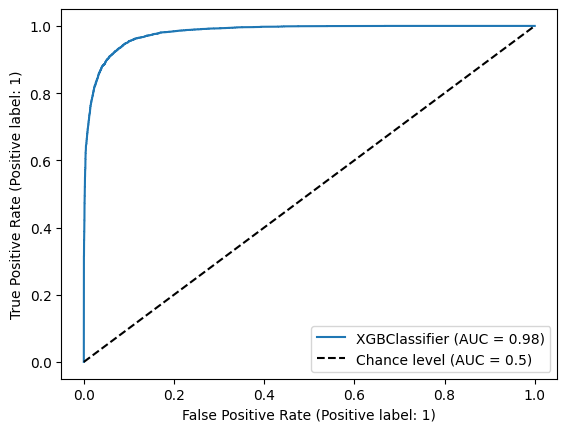

KeyboardInterrupt: 

In [244]:
## Bagging classifier

bgg_clf = BaggingClassifier(estimator=xgb_clf)

x = train.drop(["id",target],axis=1)
y = train[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, shuffle=True)
bgg_clf.fit(x_train, y_train)
preds = bgg_clf.predict(x_test)
preds_proba = bgg_clf.predict_proba(x_test)
print(f"Accuracy score on own test set: {bgg_clf.score(x_test, y_test)}")
print(f"Area under ROC curve on own test set: {roc_auc_score(y_test, preds_proba[:,1])}")
#skplt.metrics.plot_roc_curve(y_test, lg_clf.predict_proba(x_test))
fpr, tpr, _ = metrics.roc_curve(y_test, preds_proba[:,1])
auc = round(metrics.roc_auc_score(y_test, preds_proba[:,1]), 4)
ROCs.append({'tpr':tpr, 'fpr':fpr, 'label':'Bagging Classifier', 'auc':str(auc)})

RocCurveDisplay.from_estimator(xgb_clf, x_test, y_test, plot_chance_level=True)
plt.show()

# Output for Kaggle's test set
test_preds = bgg_clf.fit(x, y).predict_proba(test.drop(["id"], axis=1))
submission = pd.DataFrame({'id':test.id, 'smoking':test_preds[:,1]})
submission.to_csv("./output/bgg_submission.csv", index=False)

## Classifying using a neural network   

In [239]:
x = train.drop(["id",target],axis=1)
y = train[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, shuffle=True)

train_set = torch.tensor(x_train.values.astype(float), dtype=torch.float32)
train_target = torch.tensor(y_train.values.astype(float), dtype=torch.float32)

# own test set
pred_set = torch.tensor(x_test.values.astype(float),dtype=torch.float32)
# test set for Kaggle submission
test_pred_set = torch.tensor(test.drop(['id'], axis=1).values.astype(float),dtype=torch.float32)
input_dim = train_set.shape[1]

In [240]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return self.sigmoid(x)

Epoch [10/1000], Loss: 0.7345
Epoch [20/1000], Loss: 0.7094
Epoch [30/1000], Loss: 0.6855
Epoch [40/1000], Loss: 0.6694
Epoch [50/1000], Loss: 0.6537
Epoch [60/1000], Loss: 0.6397
Epoch [70/1000], Loss: 0.6341
Epoch [80/1000], Loss: 0.6247
Epoch [90/1000], Loss: 0.6177
Epoch [100/1000], Loss: 0.6126
Epoch [110/1000], Loss: 0.6073
Epoch [120/1000], Loss: 0.6034
Epoch [130/1000], Loss: 0.6016
Epoch [140/1000], Loss: 0.5972
Epoch [150/1000], Loss: 0.5922
Epoch [160/1000], Loss: 0.5910
Epoch [170/1000], Loss: 0.5858
Epoch [180/1000], Loss: 0.5840
Epoch [190/1000], Loss: 0.5804
Epoch [200/1000], Loss: 0.5788
Epoch [210/1000], Loss: 0.5759
Epoch [220/1000], Loss: 0.5738
Epoch [230/1000], Loss: 0.5709
Epoch [240/1000], Loss: 0.5694
Epoch [250/1000], Loss: 0.5669
Epoch [260/1000], Loss: 0.5656
Epoch [270/1000], Loss: 0.5626
Epoch [280/1000], Loss: 0.5616
Epoch [290/1000], Loss: 0.5603
Epoch [300/1000], Loss: 0.5577
Epoch [310/1000], Loss: 0.5568
Epoch [320/1000], Loss: 0.5559
Epoch [330/1000],

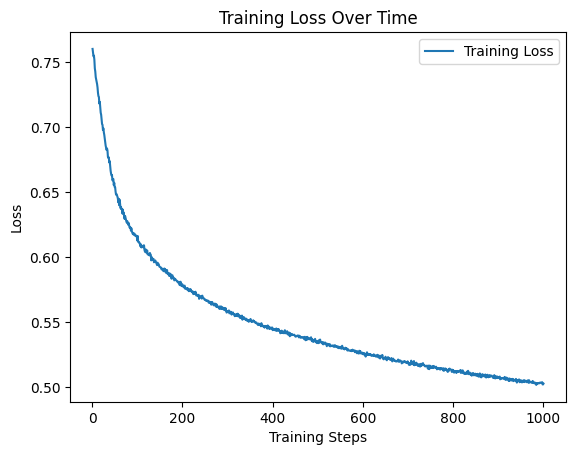

In [241]:
model = NN(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_history = []

epochs = 1000
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(train_set).squeeze()

    loss = criterion(outputs, train_target)
    loss_history.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    loss.backward()
    optimizer.step()
train_steps = range(1, len(loss_history) + 1)
plt.plot(train_steps, loss_history, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Time')
plt.show()

In [242]:
# Prediction on own test set

model.eval()
with torch.no_grad():
    probs = model(pred_set)

preds_proba = probs.cpu().flatten().numpy()
print(f"Area under ROC curve on own test set: {roc_auc_score(y_test, preds_proba)}")
#skplt.metrics.plot_roc_curve(y_test, lg_clf.predict_proba(x_test))
fpr, tpr, _ = metrics.roc_curve(y_test, preds_proba)
auc = round(metrics.roc_auc_score(y_test, preds_proba), 4)
ROCs.append({'tpr':tpr, 'fpr':fpr, 'label':'Neural Network', 'auc':str(auc)})

# Prediction on Kaggle's test set
with torch.no_grad():
    probs = model(test_pred_set)

preds_proba = probs.cpu().flatten().numpy()
submission = pd.DataFrame({'id':test.id, 'smoking':preds_proba})
submission.to_csv("./output/nn_submission.csv", index=False)


Area under ROC curve on own test set: 0.8455875315273053


## Results

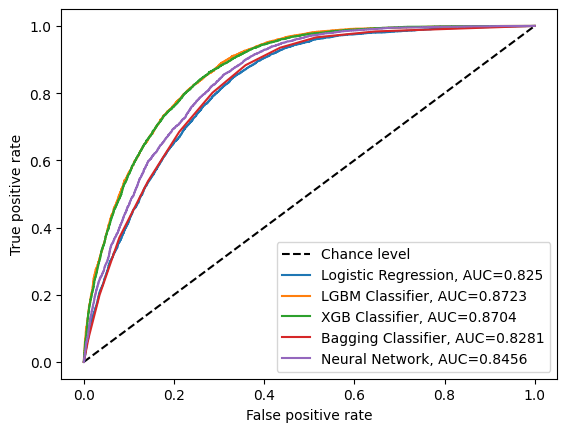

In [243]:
plt.figure(0).clf()

plt.plot([0,1], [0,1], '--k', label='Chance level')

for roc_data in ROCs:
    plt.plot(roc_data['fpr'], roc_data['tpr'], label=f"{roc_data['label']}, AUC={roc_data['auc']}")

plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()